In [5]:
import sys, os
import pandas as pd
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import astropy
import shutil
import pyoperon as Operon
from iminuit import Minuit
from iminuit.cost import LeastSquares
import seaborn as sns
from os import listdir
from os.path import isfile, join
from scipy.optimize import curve_fit

sys.path.append('../')
import mvsr as mvsr
import analysis as ana

## Format the data

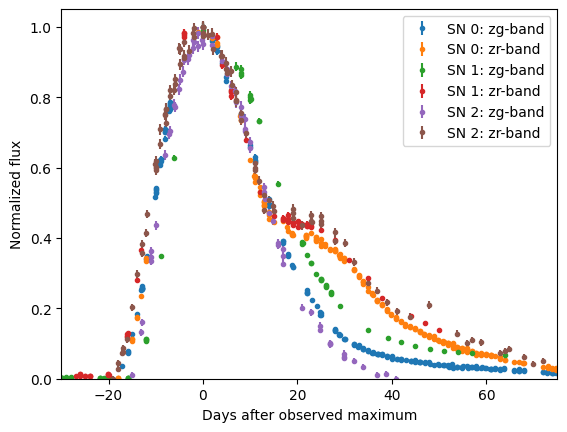

In [8]:
folder = "supernovae/examples"

def toflux(mag, magerr):
    flux = 10 ** (-0.4 * mag) * 10 ** (11)
    fluxerr = 9.21034 * 10**10 * np.exp(-0.921034 * mag) * magerr
    return flux, fluxerr
    
# Delete and recreate folder
if os.path.exists(f"{folder}"):
    shutil.rmtree(f"{folder}")
os.makedirs(f"{folder}")

onlyfiles = [f for f in listdir("supernovae/") if isfile(join("supernovae/", f))]

n_example = 0
plot_error = []
for nfile, i in enumerate(onlyfiles):
    for band in ['zg', 'zr']: #, 'zr', 'zi'
        data = pd.read_csv(f"supernovae/{i}")
        lc = data[data['filter']==band]
        mag, magerr, mjd = lc['mag'], lc['magerr'], lc['mjd']    
        mjd = mjd - mjd.iloc[np.argmin(mag)]
        flux, fluxerr = toflux(mag, magerr)
        mask = ((mjd>-50) & (mjd<150)) & ((flux/fluxerr)>20)
        flux, fluxerr, mjd = flux[mask], fluxerr[mask], mjd[mask]
        if len(flux)> 10:
            n_example += 1
            flux -= flux.min()
            flux, fluxerr = flux/flux.max(), fluxerr/flux.max()
            
            plot_error.append(fluxerr)
            plt.errorbar(mjd, flux, yerr=fluxerr, fmt='.', label=f"SN {nfile}: {band}-band")
            ana.save_2D_example(mjd, flux, f'{folder}/example{n_example}.csv')

            plt.ylim([0, 1.05])
            plt.xlim([-30, 75])

plt.xlabel('Days after observed maximum')
plt.ylabel('Normalized flux')
plt.legend()

## Generate small solution (3p)

In [10]:
agg_best_str, all_best_str = mvsr.MultiViewSR(folder, maxL=12, maxD=3, generations=3000, seed=26, 
                                              OperationSet=Operon.NodeType.Exp|Operon.NodeType.Pow|Operon.NodeType.Square,\
                                              verbose=False, explicit_params=False)

func1, func_str1, initial_guess1 = ana.convert_string_to_func(agg_best_str, 1)
print("f(X1) =", func_str1)

f(X1) = exp(-A*X1)**(B - exp(-C*X1))


## Generate Bazin (4p)

In [11]:
agg_best_str, all_best_str = mvsr.MultiViewSR(folder, maxL=12, maxD=3, generations=3000, seed=0, 
                                              OperationSet=Operon.NodeType.Exp|Operon.NodeType.Pow|Operon.NodeType.Square,\
                                              verbose=False, explicit_params=False)

func2, func_str2, initial_guess2 = ana.convert_string_to_func(agg_best_str, 1)
print("f(X1) =", func_str2)

f(X1) = A/(B*exp(C*X1) + exp(-D*X1))


## Generate big solution (5p)

In [14]:
agg_best_str, all_best_str = mvsr.MultiViewSR(folder, maxL=12, maxD=3, generations=3000, seed=3, 
                                              OperationSet=Operon.NodeType.Exp|Operon.NodeType.Pow|Operon.NodeType.Square,\
                                              verbose=False, explicit_params=False)

func3, func_str3, initial_guess3 = ana.convert_string_to_func(agg_best_str, 1)
print("f(X1) =", func_str3)

f(X1) = A**(B*X1)/(C*X1 + (-D*X1 + exp(E*X1))**2)


Mean R2: 0.9915818141183492


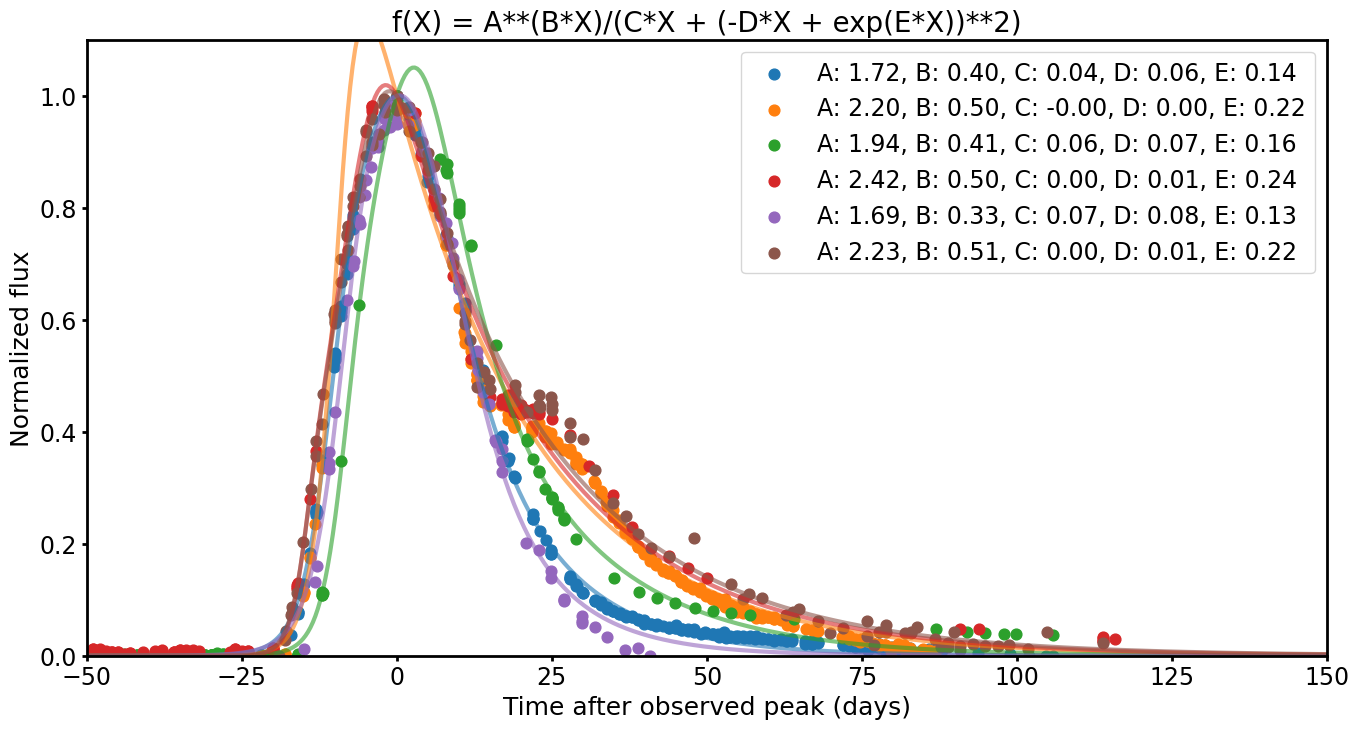

In [15]:
error_mvsr3 = ana.refit_and_plot(folder, func3, func_str3, initial_guess3,
                   [-50, 150], [0, 1.1],
                   ['Time after observed peak (days)', 'Normalized flux'],
                   folder[:folder.find('/')])

print(f'Mean R2: {np.mean(error_mvsr3)}')

## Plot the result

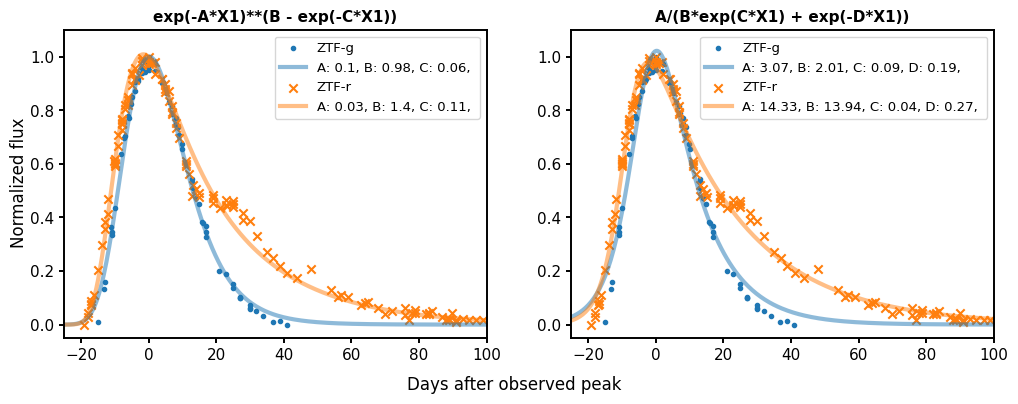

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

def bazin(t, A, B, C, D):
    return A / (B * np.exp(C*t) + np.exp(-D*t))

def dbexp(t, A, B, C):
    return np.exp(-A*t*(B-np.exp(-C*t)))
    
titles = [func_str1, func_str2]
funcs =  [dbexp, bazin]
initial_guesses = [initial_guess1, initial_guess2]
xbounds = [-25, 100]
markers = ['.', 'x']
labels = ['ZTF-g', 'ZTF-r']

data = pd.read_csv(f"supernovae/679215400015888.csv")

for idx, funco in enumerate(funcs):
    for idx2, band in enumerate(['zg', 'zr']):
        lc = data[data['filter']==band]
        smoothX = np.linspace(xbounds[0], xbounds[1], 300)
        mag, magerr, mjd = lc['mag'], lc['magerr'], lc['mjd']    
        mjd = mjd - mjd.iloc[np.argmin(mag)]
        flux, fluxerr = toflux(mag, magerr)
        mask = ((mjd>-50) & (mjd<150)) & ((flux/fluxerr)>20)
        flux, fluxerr, mjd = flux[mask], fluxerr[mask], mjd[mask]
        flux -= flux.min()
        flux, fluxerr = flux/flux.max(), fluxerr/flux.max()
        popt, pcov = curve_fit(funco, mjd, flux, p0=list(initial_guesses[idx].values()), maxfev = 50000)

        pnames = [letter for letter in list(initial_guesses[idx])]
        display = ''.join([pnames[k]+": "+str(round(popt[k], 2))+", " for k in range(len(popt))])

        ax[idx].scatter(mjd, flux, marker=markers[idx2], label=labels[idx2])
        ax[idx].plot(smoothX, funco(smoothX, *popt), label=display,\
        alpha=.5, linewidth=3)

        ax[idx].set_xlim(xbounds[0], xbounds[1])
        ax[idx].set_ylim(-.05, 1.1)
        ax[idx].legend()
        ax[idx].set_title(titles[idx], fontsize=11, fontweight='bold')
    
        for axis in ['top','bottom','left','right']:
            for axee in ax:
                axee.spines[axis].set_linewidth(1.4)

        ax[idx].tick_params(width=1.4)
        ax[idx].tick_params(labelsize=11)
        ax[idx].legend(fontsize = 9.5)

fig.text(0.5, -.02, 'Days after observed peak', ha='center', fontsize=12)
fig.text(0.08, 0.5, 'Normalized flux', va='center', rotation='vertical', fontsize=12);

fig.savefig('plots/SN_plot.pdf', bbox_inches="tight")